# Ro5 and beyond Ro5 overview of compounds
This notebook calculates the distribution of compounds following the Ro5 and bRo5 properties.

# Import Modules

In [1]:
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

from rdkit import Chem, RDLogger
from rdkit.Chem.EnumerateStereoisomers import GetStereoisomerCount
from rdkit.Chem import Draw, Descriptors

import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
RDLogger.DisableLog("rdApp.*")
pd.options.mode.chained_assignment = None  # default='warn'

# Add path constants

In [3]:
DATA_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
MAPPING_DIR = "../data/mappings"
FIGURE_DIR = "../data/figures"

# Load data file

We generated a smiles dataframe with desalting smiles. The code block below can help replicate the steps. 

In [4]:
surechembl_df = pd.read_parquet(f"{DATA_DIR}/surechembl_dump.pq")
unique_cmpd_df = surechembl_df.drop_duplicates(subset=["SMILES"])

In [5]:
year_df = pd.read_parquet(f"{PROCESSED_DIR}/patent_data_desalted.pq")
year_df.head(2)

,SMILES,year,cleaned_smiles
0,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
1757,O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...,2015,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...


# Load properties data dump

In [6]:
property_df = pd.read_csv(
    f"{MAPPING_DIR}/property_data.tsv", sep="\t", low_memory=False
)

In [7]:
property_combined_df = pd.merge(
    property_df, year_df, how="left", left_on="SMILES", right_on="cleaned_smiles"
)
property_combined_df.drop(columns=["cleaned_smiles"], inplace=True)
property_combined_df.rename(
    columns={"SMILES_x": "desalted_SMILES", "SMILES_y": "SMILES"}, inplace=True
)
property_combined_df.head(2)

,desalted_SMILES,mw,logp,n_hba,n_hbd,tpsa,rot_bonds,fsp3,n_ring,n_heteroatoms,n_chiral,SMILES,year
0,C1=C2C(c3ccc(-c4cccc5ccccc45)cc3)=NC(n3c4ccccc...,604.226312,9.5483,5,0,43.81,3,0.047619,10,5,2,C1OC=C2C1N=C(N=C2C1=CC=C(C=C1)C1=CC=CC2=C1C=CC...,2015
1,C=CCOC(=O)[C@@H]1C[C@]2(C(C)Cc3ccc(OC)c(C=O)c3...,400.152203,2.6315,7,0,88.13,8,0.409091,3,7,2,COC1=C(C=O)C=C(CC(C)[C@]23C[C@@H](C(=O)OCC=C)C...,2017


In [8]:
smiles_to_inchikey_dict = dict(
    zip(unique_cmpd_df["SMILES"], unique_cmpd_df["InChIKey"])
)

In [9]:
property_combined_df["inchikey"] = property_combined_df["SMILES"].map(
    smiles_to_inchikey_dict
)

# Calculating Ro5 critera for compounds

In [10]:
def is_ro5_compliant(row):
    """Check if a molecule is Ro5 or bRo5 compliant."""
    # All properties need compliance
    if (
        row.mw <= 500
        and row.n_hba <= 10
        and row.n_hbd <= 5
        and row.logp <= 5
        and row.rot_bonds <= 10
        and row.tpsa <= 140
    ):
        return "Ro5"

    # Only MW + one other property needs compliance
    if 500 < row.mw < 3000:
        if (
            row.n_hba > 10
            or row.n_hbd > 5
            or row.logp > 7.5
            or row.logp < 0
            or row.rot_bonds > 20
            or row.tpsa > 200
        ):
            return "bRo5"

    return "Neither"

In [11]:
ro5_annotation = property_combined_df.progress_apply(is_ro5_compliant, axis=1)
property_combined_df["ro5"] = ro5_annotation

100%|██████████| 10695537/10695537 [02:11<00:00, 81609.53it/s]


In [12]:
ro5_property_combined_df = property_combined_df[["inchikey", "ro5"]].drop_duplicates()

In [13]:
ro5_counts = ro5_property_combined_df.ro5.value_counts().to_dict()
total = sum(ro5_counts.values())

for i in ro5_counts:
    print(f"{i}: {ro5_counts[i]} ({ro5_counts[i]/total*100:.2f}%)")

Ro5: 5912331 (55.43%)
Neither: 3033310 (28.44%)
bRo5: 1720436 (16.13%)


# Looking into proprotion of approved drugs with the drug-likeness rules

In [14]:
drugbank_df = pd.read_csv(f"{DATA_DIR}/drugbank_approved_structure_links.csv.zip")

In [15]:
is_approved = []

for inchikey in tqdm(ro5_property_combined_df["inchikey"]):
    if inchikey in drugbank_df["InChIKey"].values:
        is_approved.append("Approved")
    else:
        is_approved.append("Not Approved")

ro5_property_combined_df["approved"] = is_approved

100%|██████████| 10666077/10666077 [06:21<00:00, 27934.56it/s]


In [16]:
approved_patented_drugs = ro5_property_combined_df[
    ro5_property_combined_df["approved"] == "Approved"
]
non_approved_patented_drugs = ro5_property_combined_df[
    ro5_property_combined_df["approved"] == "Not Approved"
]
len(approved_patented_drugs), len(non_approved_patented_drugs)

(2100, 10663977)

In [17]:
t = approved_patented_drugs["ro5"].value_counts(normalize=True).to_dict()
k = non_approved_patented_drugs["ro5"].value_counts(normalize=True).to_dict()

df = pd.DataFrame([t, k]).T
df.columns = ["Approved", "Non-approved"]
df["Approved"] = df["Approved"].apply(lambda x: x * 100)
df["Non-approved"] = df["Non-approved"].apply(lambda x: x * 100)

In [18]:
df

,Approved,Non-approved
Ro5,66.761905,55.428936
Neither,22.904762,28.439943
bRo5,10.333333,16.131121


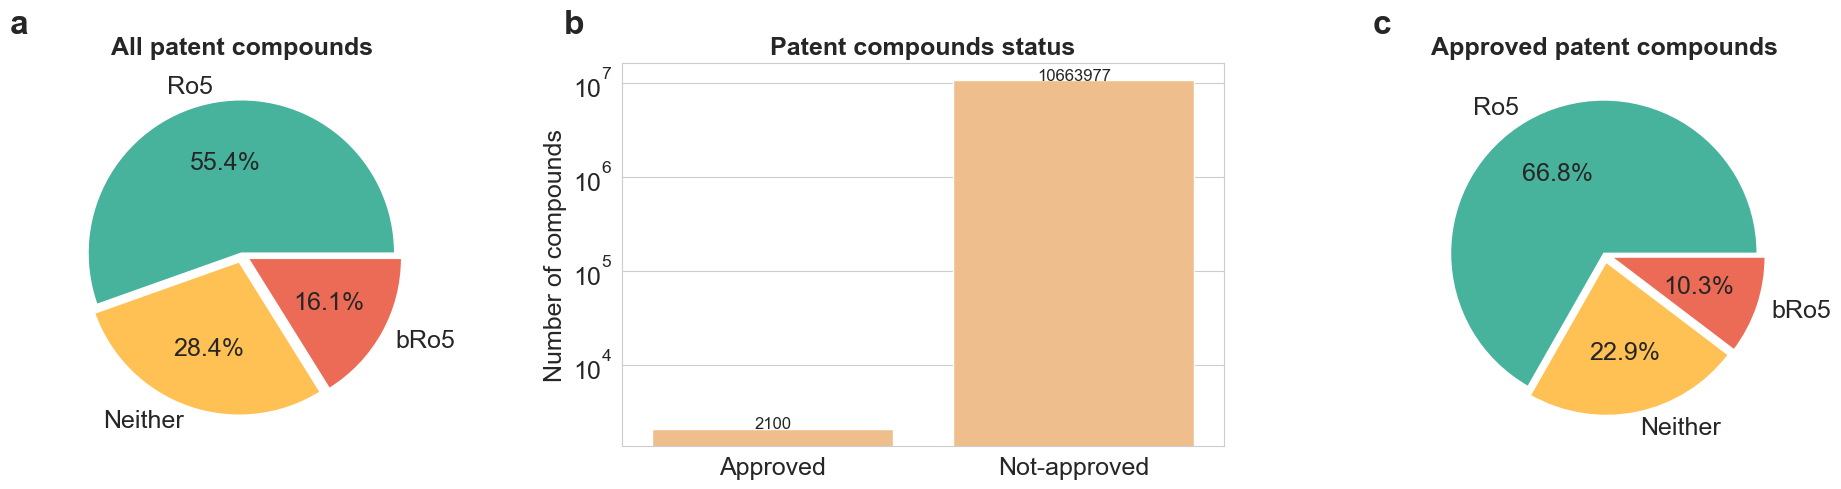

In [19]:
sns.set_style("whitegrid")

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.pie(
    [55.43, 28.44, 16.13],
    autopct="%1.1f%%",
    labels=["Ro5", "Neither", "bRo5"],
    colors=["#47B39C", "#FFC154", "#EC6B56"],
    explode=(0.01, 0.05, 0.05),
    textprops={"fontsize": 18},
)
plt.gca().set_title("All patent compounds", fontsize=18, fontweight="bold")
plt.text(
    -0.08,
    1.1,
    "a",
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(1, 3, 2)
ax = sns.barplot(
    x=["Approved", "Not-approved"],
    y=[len(approved_patented_drugs), len(non_approved_patented_drugs)],
    color="#ffbe7d",
)

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", fontsize=12)

plt.ylabel("Number of compounds", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
plt.gca().set_title("Patent compounds status", fontsize=18, fontweight="bold")
plt.text(
    -0.08,
    1.1,
    "b",
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(1, 3, 3)
plt.pie(
    [
        df["Approved"]["Ro5"],
        df["Approved"]["Neither"],
        df["Approved"]["bRo5"],
    ],
    autopct="%1.1f%%",
    labels=["Ro5", "Neither", "bRo5"],
    colors=["#47B39C", "#FFC154", "#EC6B56"],
    explode=(0.01, 0.05, 0.05),
    textprops={"fontsize": 18},
)
plt.gca().set_title("Approved patent compounds", fontsize=18, fontweight="bold")
plt.text(
    -0.08,
    1.1,
    "c",
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.savefig(f"{FIGURE_DIR}/figure_5.png", dpi=400)
plt.savefig(f"{FIGURE_DIR}/figure_5.pdf", dpi=400)
plt.show()

# Looking into the top 5 compounds within each category

The top five compounds were selected based on their number of patents

In [20]:
patent_counter_dict = defaultdict(set)
surechembl_map = defaultdict(str)

for idx, smile, patent_idx in tqdm(
    surechembl_df[["SureChEMBL_ID", "SMILES", "PATENT_ID"]].values
):
    patent_counter_dict[smile].add(patent_idx)
    surechembl_map[smile] = idx

patent_counter_dict = {k: len(v) for k, v in patent_counter_dict.items()}

100%|██████████| 133512452/133512452 [01:54<00:00, 1170387.87it/s]


In [21]:
property_combined_df

,desalted_SMILES,mw,logp,n_hba,n_hbd,tpsa,rot_bonds,fsp3,n_ring,n_heteroatoms,n_chiral,SMILES,year,inchikey,ro5
0,C1=C2C(c3ccc(-c4cccc5ccccc45)cc3)=NC(n3c4ccccc...,604.226312,9.5483,5,0,43.81,3,0.047619,10,5,2,C1OC=C2C1N=C(N=C2C1=CC=C(C=C1)C1=CC=CC2=C1C=CC...,2015,IGMVYZDJOYXYIY-UHFFFAOYSA-N,bRo5
1,C=CCOC(=O)[C@@H]1C[C@]2(C(C)Cc3ccc(OC)c(C=O)c3...,400.152203,2.6315,7,0,88.13,8,0.409091,3,7,2,COC1=C(C=O)C=C(CC(C)[C@]23C[C@@H](C(=O)OCC=C)C...,2017,UQNPKFOQBTVDPH-XAFZNHKBSA-N,Ro5
2,CCCCCc1ccc(-c2cccnc2)cc1,225.151750,4.4813,1,0,12.89,5,0.312500,2,1,1,CCCCCC1=CC=C(C=C1)C1=CC=CN=C1,2015,QMAVMBNUGSEKLJ-UHFFFAOYSA-N,Ro5
3,CCC1CNCCc2cc(F)c(Cl)cc21,227.087705,3.1184,1,1,12.03,1,0.500000,2,3,2,CCC1CNCCC2=C1C=C(Cl)C(F)=C2,2015,FAVBYFITEFEUJI-UHFFFAOYSA-N,Ro5
4,CC1=C(O)C(=O)C=C2C1=CC=C1[C@@]2(C)CC[C@@]2(C)[...,792.409815,6.2592,9,4,171.21,9,0.565217,8,12,2,CC1=C(O)C(=O)C=C2C1=CC=C1[C@@]2(C)CC[C@@]2(C)[...,2022,PYFBJKIPNAUJBT-JWUFHTLTSA-N,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695532,CCC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC...,515.300873,5.1239,8,2,87.55,11,0.344828,4,9,1,CCN(C)CCN(C)C1=CC(OC)=C(NC2=NC(=CC=N2)C2=CN(C)...,2019,RFLMXEZGRHGGGW-UHFFFAOYSA-N,Neither
10695533,CC(C)(C)OC(=O)N1CCC(CNc2ccc(I)cc2)CC1,416.096076,4.3502,3,1,41.57,3,0.588235,2,5,1,CC(C)(C)OC(=O)N1CCC(CNC2=CC=C(I)C=C2)CC1,2015,ZJDIVFBFYVYSMH-UHFFFAOYSA-N,Ro5
10695534,CCc1ccc(OC)c(S(=O)(=O)Nc2ccc3c(c2)C(N(C)C(=O)C...,522.218843,5.1455,5,1,84.94,9,0.344828,4,8,2,CCC1=CC(=C(OC)C=C1)S(=O)(=O)NC1=CC2=C(CCCC2N(C...,2021,DNDRYHSJZKGJOT-UHFFFAOYSA-N,Neither
10695535,COc1cc(-c2cnc3cc(C4(C(=O)O)CC4)ccn23)cc(OC(F)F...,457.144927,3.6197,6,2,102.16,8,0.347826,5,10,1,COC1=C(C(=O)NC2CC2)C(OC(F)F)=CC(=C1)C1=CN=C2C=...,2020,HJZVBDWTZIDKSK-UHFFFAOYSA-N,Ro5


In [22]:
property_combined_df["patent_count"] = property_combined_df["SMILES"].map(
    patent_counter_dict
)

In [23]:
subset_df = property_combined_df[["SMILES", "ro5", "patent_count"]].copy()
subset_df["schembl"] = subset_df["SMILES"].map(surechembl_map)
subset_df.head()

,SMILES,ro5,patent_count,schembl
0,C1OC=C2C1N=C(N=C2C1=CC=C(C=C1)C1=CC=CC2=C1C=CC...,bRo5,1,SCHEMBL16613280
1,COC1=C(C=O)C=C(CC(C)[C@]23C[C@@H](C(=O)OCC=C)C...,Ro5,1,SCHEMBL18466885
2,CCCCCC1=CC=C(C=C1)C1=CC=CN=C1,Ro5,2,SCHEMBL15060898
3,CCC1CNCCC2=C1C=C(Cl)C(F)=C2,Ro5,7,SCHEMBL1095696
4,CC1=C(O)C(=O)C=C2C1=CC=C1[C@@]2(C)CC[C@@]2(C)[...,Neither,1,SCHEMBL24297572


# Get the top compound hits

In [24]:
k = (
    subset_df[subset_df["ro5"] == "Ro5"]
    .sort_values(by="patent_count", ascending=False)
    .head(5)
)
mols = [Chem.MolFromSmiles(s) for s in k["SMILES"]]

for idx, mol in enumerate(mols):
    idx = idx + 1
    Draw.MolToFile(mol, f"{FIGURE_DIR}/ro5_mol{idx}.png", size=(600, 600))

In [25]:
k

,SMILES,ro5,patent_count,schembl
1057377,OC[C@@H](O)[C@H](O)[C@@H](O)C(=O)CO,Ro5,242495,SCHEMBL762
2950679,NC(CCCNC(N)=N)C(O)=O,Ro5,196444,SCHEMBL1790
3558655,OC(=O)C1=CC=CC=C1,Ro5,188165,SCHEMBL1378
6185255,OCC(O)C(O)C(O)C(O)C=O,Ro5,176495,SCHEMBL1812
4495640,N[C@@H](CC1=CNC=N1)C(O)=O,Ro5,163871,SCHEMBL3259


In [26]:
m = (
    subset_df[subset_df["ro5"] == "bRo5"]
    .sort_values(by="patent_count", ascending=False)
    .head(5)
)
mols_2 = [Chem.MolFromSmiles(s) for s in m["SMILES"]]

for idx, mol in enumerate(mols_2):
    idx = idx + 1
    Draw.MolToFile(mol, f"{FIGURE_DIR}/bro5_mol{idx}.png", size=(600, 600))

In [27]:
m

,SMILES,ro5,patent_count,schembl
1554474,CC(=O)N[C@H]1[C@H](O)O[C@@H](COS(O)(=O)=O)[C@@...,bRo5,97039,SCHEMBL11557
7820557,CC(=O)O[C@@H]1C2=C(C)[C@H](C[C@@](O)([C@@H](OC...,bRo5,95174,SCHEMBL3976
5678486,COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@](O)(C[C@@H...,bRo5,92479,SCHEMBL3243
1604274,CN[C@H]1[C@H](O)[C@@H](O)[C@H](CO)O[C@H]1O[C@H...,bRo5,90734,SCHEMBL3276
10289385,C[C@@H](O)[C@H](NC(=O)[C@@H](C)[C@H](O)[C@@H](...,bRo5,73429,SCHEMBL1599
